In [1]:
!pip install --upgrade gspread gspread_dataframe prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.2 MB/s eta 0:00:00


In [29]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)
# Replace with the actual sheet name visible in Google Sheets
sheet = gc.open("response").sheet1


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from gspread_dataframe import get_as_dataframe
import seaborn as sns
import prince
import plotly.graph_objects as go


In [32]:
sheet = gc.open("df_augmented").sheet1
df = get_as_dataframe(sheet)

# Drop rows that are completely empty
df.dropna(how='all', inplace=True)
def standardize_income_column(df, column='income_2'):
    def format_income(val):
        try:
            # Remove common non-numeric characters and convert to float
            val = str(val).replace('£', '').replace(',', '').strip()
            num = int(float(val))  # Handles values like "3000.0"
            return f'£{num}'
        except:
            return np.nan  # Or return the original val if you prefer: return val

    df[column] = df[column].apply(format_income)
    return df
df = standardize_income_column(df, column='income_2')


/tmp/ipython-input-349664278.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




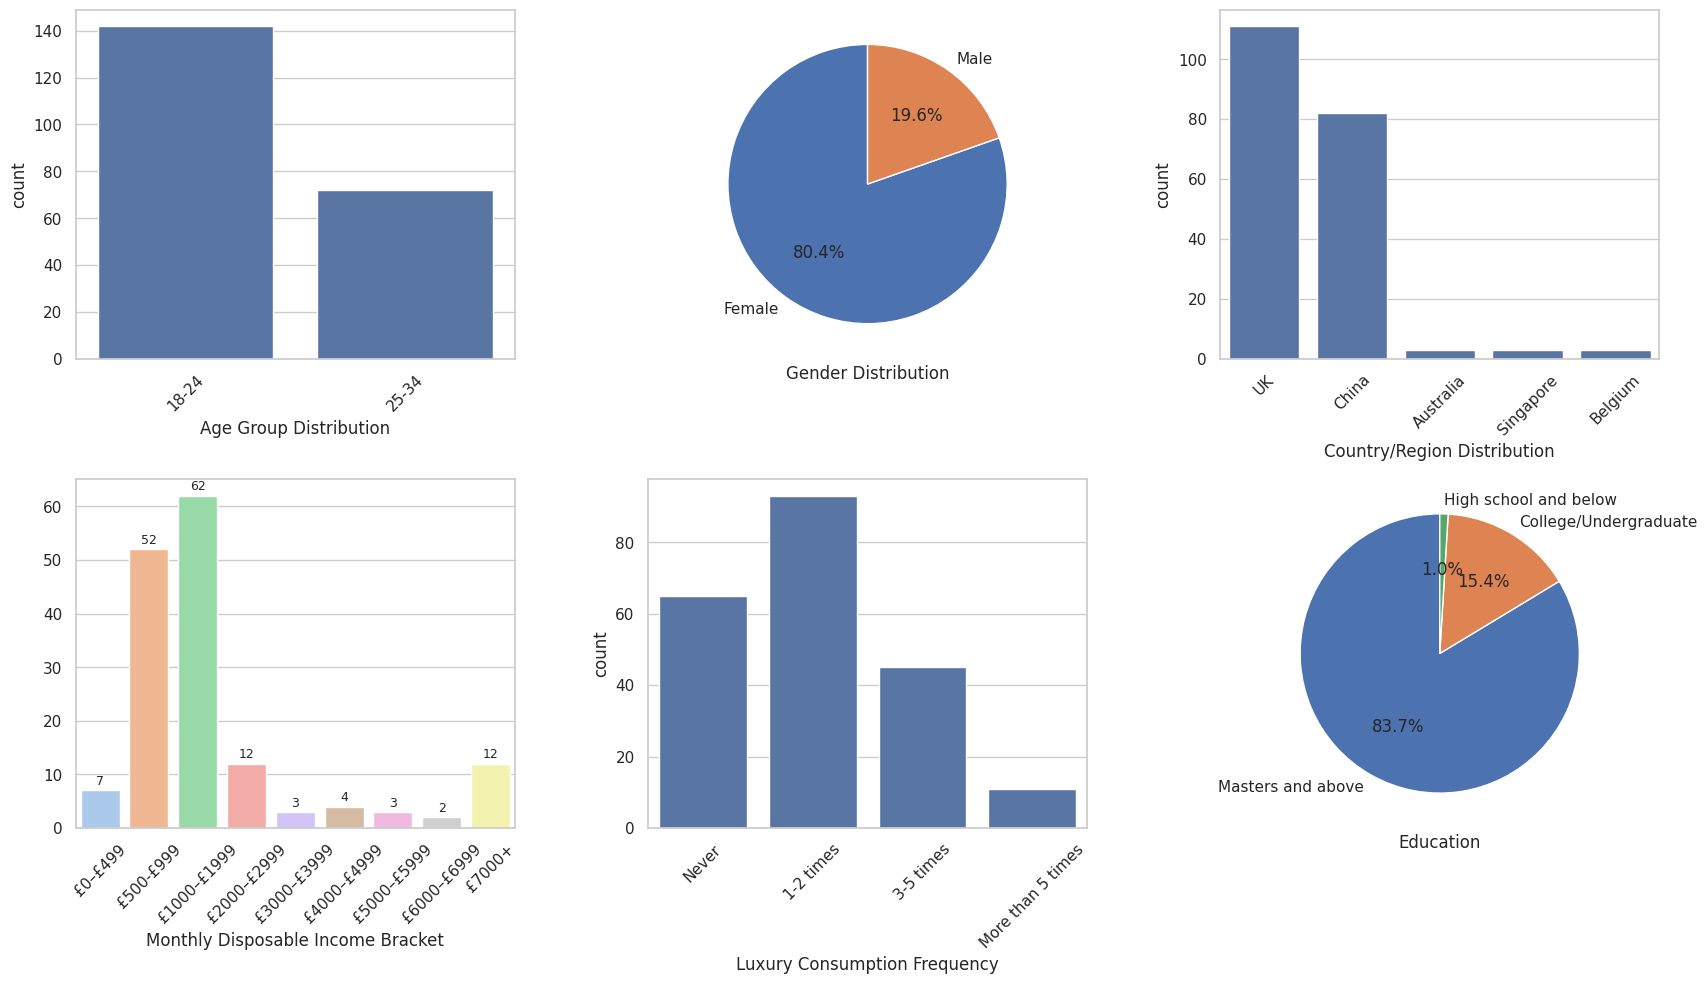

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.rcParams['font.family'] = 'Times New Roman'  # or 'Arial', 'DejaVu Sans', etc.
plt.rcParams['font.size'] = 12  # default font size for all text

sns.set(style='whitegrid')

# Define your income brackets (in order)
income_brackets = ['£0–£499', '£500-£999', '£1000–£1999', '£2000–£2999', '£3000–£3999', '£4000–£4999', '£5000–£5999', '£6000–£6999', '£7000+']

# Parse brackets into numeric ranges
def parse_bracket(bracket):
    if '+' in bracket:
        start = int(re.findall(r'\d+', bracket)[0])
        return (start, float('inf'))
    else:
        nums = list(map(int, re.findall(r'\d+', bracket)))
        return (nums[0], nums[1])

bins = [parse_bracket(b) for b in income_brackets]

# Extract numeric income from string (e.g. '£2500' -> 2500)
def extract_income(val):
    if pd.isna(val):
        return None
    match = re.search(r'\d+', val.replace(',', ''))
    return int(match.group()) if match else None

# Assign each income value to the proper bracket label
def assign_bracket(value):
    if value is None:
        return None
    for i, (start, end) in enumerate(bins):
        if start <= value <= end:
            return income_brackets[i]
    return None

# Extract income numeric values
income_values = df.iloc[:, 7].apply(extract_income)
# Map incomes to brackets
income_bracket_assigned = income_values.apply(assign_bracket)
# Count per bracket in fixed order, fill missing with 0
income_counts = income_bracket_assigned.value_counts().reindex(income_brackets, fill_value=0)

# Top 10 countries for consistency
top_10_countries = df.iloc[:, 4].value_counts().nlargest(10).index

# Setup figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
plt.tight_layout(pad=5.0)

# 1. Age Group Distribution
sns.countplot(x=df.iloc[:, 1], order=df.iloc[:, 1].value_counts().index, ax=axs[0, 0])
#axs[0, 0].set_title("Age Group Distribution", fontsize=12)
axs[0, 0].set_xlabel("Age Group Distribution")
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Gender Distribution (Pie Chart)
df.iloc[:, 2].value_counts().plot.pie(
    labels=df.iloc[:, 2].value_counts().index,
    autopct='%1.1f%%',
    startangle=90,
    ax=axs[0, 1]
)
#axs[0, 1].set_title("Gender Distribution", fontsize=12)
axs[0, 1].set_xlabel("Gender Distribution")
axs[0, 1].set_ylabel('')

# 3. Country/Region Distribution (Top 10)
sns.countplot(x=df.iloc[:, 4], order=top_10_countries, ax=axs[0, 2])
#axs[0, 2].set_title("Top 10 Respondent Countries", fontsize=12)
axs[0, 2].set_xlabel("Country/Region Distribution")
axs[0, 2].tick_params(axis='x', rotation=45)

# 4. Disposable Income Bracket (Binned properly)
sns.barplot(x=income_counts.index, y=income_counts.values, ax=axs[1, 0], palette='pastel')
#axs[1, 0].set_title("Disposable Income Bracket", fontsize=12)
axs[1, 0].set_xlabel('Monthly Disposable Income Bracket')
axs[1, 0].tick_params(axis='x', rotation=45)
# Annotate each bar with its height (count)
for i, v in enumerate(income_counts.values):
    axs[1, 0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

# 5. Luxury Consumption Frequency
order_list = list(df.iloc[:, 8].value_counts().index)
order_list[0], order_list[1] = order_list[1], order_list[0]
sns.countplot(x=df.iloc[:, 8], order=order_list, ax=axs[1, 1])
#sns.countplot(x=df.iloc[:, 8], order=df.iloc[:, 8].value_counts().index, ax=axs[2, 0])
#axs[1, 1].set_title("Luxury Consumption Frequency", fonptsize=12)
axs[1, 1].set_xlabel('Luxury Consumption Frequency')
axs[1, 1].tick_params(axis='x', rotation=45)

# Education
df.iloc[:, 5].value_counts().plot.pie(
    labels=df.iloc[:, 5].value_counts().index,
    autopct='%1.1f%%',
    startangle=90,
    ax=axs[1, 2]
)
axs[1, 2].set_xlabel("Education")
axs[1, 2].set_ylabel('')

# Remove empty subplot (bottom right)
#fig.delaxes(axs[1, 2])

# Add overall figure title
plt.subplots_adjust(top=0.93)
#fig.suptitle("Participant Profile Summary", fontsize=16,)

plt.show()


In [8]:
cols = ["age",
    "gender",
    "country_region_2",
    "education_level",
    "income_2",
    "luxury_purchase_freq",]
def describe_single_column(df, col):
  # Frequency Distributions
  print(df[col].value_counts(normalize=False).sort_index())
for col in cols:
  describe_single_column(df, col)

age
18-24    142
25-34     72
Name: count, dtype: int64
gender
Female    172
Male       42
Name: count, dtype: int64
country_region_2
Australia      3
Belgium        3
China         82
Singapore      3
UK           111
Name: count, dtype: int64
education_level
College/Undergraduate     32
High school and below      2
Masters and above        174
Name: count, dtype: int64
income_2
£1000     21
£10000     3
£1100      9
£11000     1
£11800     1
£1200     17
£1300      3
£1500      6
£15300     1
£15400     1
£1600      1
£1700      3
£1800      1
£1900      1
£2000      7
£20000     1
£2200      1
£2300      3
£2500      1
£300       1
£3000      2
£3800      1
£400       6
£4100      1
£4400      1
£4600      1
£4700      1
£500       9
£5000      3
£600      10
£6000      1
£6400      1
£700       9
£800      13
£8300      1
£8400      1
£8500      1
£900      11
£9300      1
Name: count, dtype: int64
luxury_purchase_freq
1-2 times            93
3-5 times            45
More than 5 tim

In [69]:
df['country_region_2'] = df['country_region_2'].replace({
    'UK': 'Europe',
    'Belgium ': 'Europe',
    'Belgium': 'Europe',
    'Australia': 'Europe',
    'China': 'Asia',
    'Singapore': 'Asia'
})

# Aim 1: Consumer Attitudes Toward Sustainable Luxury Materials

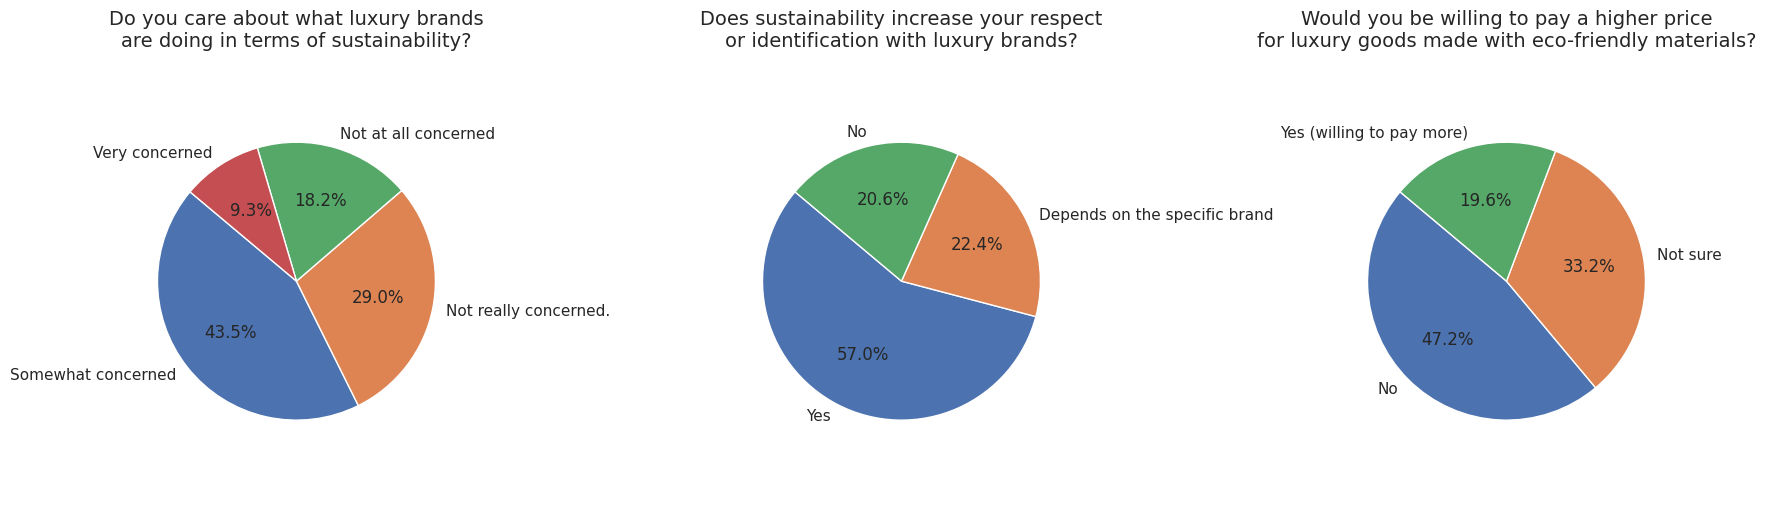

In [43]:
# Define column indices and wrapped titles
columns = [9, 10, 11]
titles = [
    "Do you care about what luxury brands\nare doing in terms of sustainability?",
    "Does sustainability increase your respect\nor identification with luxury brands?",
    "Would you be willing to pay a higher price\nfor luxury goods made with eco-friendly materials?"
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # wider and taller

# Plot each pie chart
for i, ax in enumerate(axes):
    value_counts = df.iloc[:, columns[i]].value_counts(dropna=False)
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(titles[i], fontsize=14, wrap=True)
    ax.axis('equal')

plt.tight_layout(pad=3.0)  # more padding between subplots
plt.show()

In [11]:
# Column 13-16
cols = ["recycled_materials_less_premium",
    "sustainability_affects_loyalty",
    "scarcity_vs_materials",
    "luxury_from_sustainable_materials",]
def describe_single_column(df, col):
  # Descriptive Statistics
  print(df[col].mean(), df[col].median(), df[col].mode(), df[col].std(), df[col].count())
  # Frequency Distributions
  print(df[col].value_counts(normalize=False).sort_index())
for col in cols:
  describe_single_column(df, col)

3.170616113744076 3.0 0    3.0
Name: recycled_materials_less_premium, dtype: float64 1.1626280163106926 211
recycled_materials_less_premium
1.0    18
2.0    42
3.0    68
4.0    52
5.0    31
Name: count, dtype: int64
3.3364928909952605 3.0 0    3.0
Name: sustainability_affects_loyalty, dtype: float64 1.049056275986813 211
sustainability_affects_loyalty
1.0    12
2.0    29
3.0    73
4.0    70
5.0    27
Name: count, dtype: int64
2.875 3.0 0    2.0
Name: scarcity_vs_materials, dtype: float64 1.2792472122118113 208
scarcity_vs_materials
1.0    29
2.0    70
3.0    34
4.0    48
5.0    27
Name: count, dtype: int64
3.3175355450236967 3.0 0    4.0
Name: luxury_from_sustainable_materials, dtype: float64 1.198660201430097 211
luxury_from_sustainable_materials
1.0    21
2.0    29
3.0    59
4.0    66
5.0    36
Name: count, dtype: int64


In [12]:
'''
    "recycled_materials_less_premium"
    "sustainability_affects_loyalty",
    "scarcity_vs_materials",
    "luxury_from_sustainable_materials",
'''
'''
    "luxury_rating_leather",
    "luxury_rating_exotic_skin",
    "luxury_rating_recycled_plastic",
    "luxury_rating_bio_materials",
    "luxury_rating_vegan_leather",
'''
cols = ["luxury_rating_leather",
    "luxury_rating_exotic_skin",
    "luxury_rating_recycled_plastic",
    "luxury_rating_bio_materials",
    "luxury_rating_vegan_leather"]
def describe_single_column(df, col):
  # Descriptive Statistics
  print(df[col].mean(), df[col].median(), df[col].mode(), df[col].std(), df[col].count())
  # Frequency Distributions
  print(df[col].value_counts(normalize=False).sort_index())
for col in cols:
  describe_single_column(df, col)


# Compare Across Demographics
#print(df.groupby("luxury_purchase_freq")[col].mean())
#print(pd.crosstab(df["luxury_purchase_freq"], df[col], normalize='index'))  # % by luxury_purchase_freq

# Correlation Analysis
#likert_columns = ["recycled_materials_less_premium", "sustainability_affects_loyalty"]
#df[likert_columns].corr()
#sns.heatmap(df[likert_columns].corr(), annot=True, cmap='coolwarm')


3.691588785046729 4.0 0    4.0
Name: luxury_rating_leather, dtype: float64 0.8548257374318942 214
luxury_rating_leather
2.0    18
3.0    67
4.0    92
5.0    37
Name: count, dtype: int64
4.0046728971962615 4.0 0    5.0
Name: luxury_rating_exotic_skin, dtype: float64 1.1526563057425627 214
luxury_rating_exotic_skin
1.0      6
2.0     24
3.0     33
4.0     51
5.0    100
Name: count, dtype: int64
2.602803738317757 2.0 0    2.0
Name: luxury_rating_recycled_plastic, dtype: float64 1.228072113611447 214
luxury_rating_recycled_plastic
1.0    39
2.0    78
3.0    51
4.0    21
5.0    25
Name: count, dtype: int64
3.2429906542056073 3.0 0    4.0
Name: luxury_rating_bio_materials, dtype: float64 1.1973454323708295 214
luxury_rating_bio_materials
1.0    21
2.0    40
3.0    49
4.0    74
5.0    30
Name: count, dtype: int64
3.0373831775700935 3.0 0    2.0
Name: luxury_rating_vegan_leather, dtype: float64 1.198004864473653 214
luxury_rating_vegan_leather
1.0    20
2.0    61
3.0    52
4.0    53
5.0    28


In [13]:
def sankey(col_name_1, col_name_2):
  # Step 1: Create counts of each flow
  sankey_df = df.groupby([col_name_1, col_name_2]).size().reset_index(name='count')

  # Step 2: Build node labels and map to index
  left_labels = sorted(pd.unique(sankey_df[col_name_1].astype(str)))
  right_labels = sorted(pd.unique(sankey_df[col_name_2].astype(str)))

  all_labels = left_labels + right_labels
  label_to_index = {label: i for i, label in enumerate(all_labels)}
  # Normalize vertical positions (even spacing)
  def get_y_positions(n):
      return [i / (n - 1) if n > 1 else 0.5 for i in range(n)]

  y_left = get_y_positions(len(left_labels))
  y_right = get_y_positions(len(right_labels))

  # Combine into a full y list for all nodes
  y_positions = y_left + y_right

  # Step 4: Create the Sankey diagram
  fig = go.Figure(data=[go.Sankey(
      arrangement='fixed',
      node=dict(
          pad=15,
          thickness=20,
          line=dict(color="black", width=0.5),
          label=all_labels,
          y=y_positions
      ),
      link=dict(
          source=sankey_df[col_name_1].astype(str).map(label_to_index),
          target=sankey_df[col_name_2].astype(str).map(label_to_index),
          value=sankey_df['count']
      ))])
  title = str(col_name_1 + " → " + col_name_2)
  fig.update_layout(title_text=title, font_size=12)
  fig.show()

sankey("luxury_purchase_freq", "recycled_materials_less_premium")

# Aim 2: The Impact of Material Innovation on Perceived Luxury


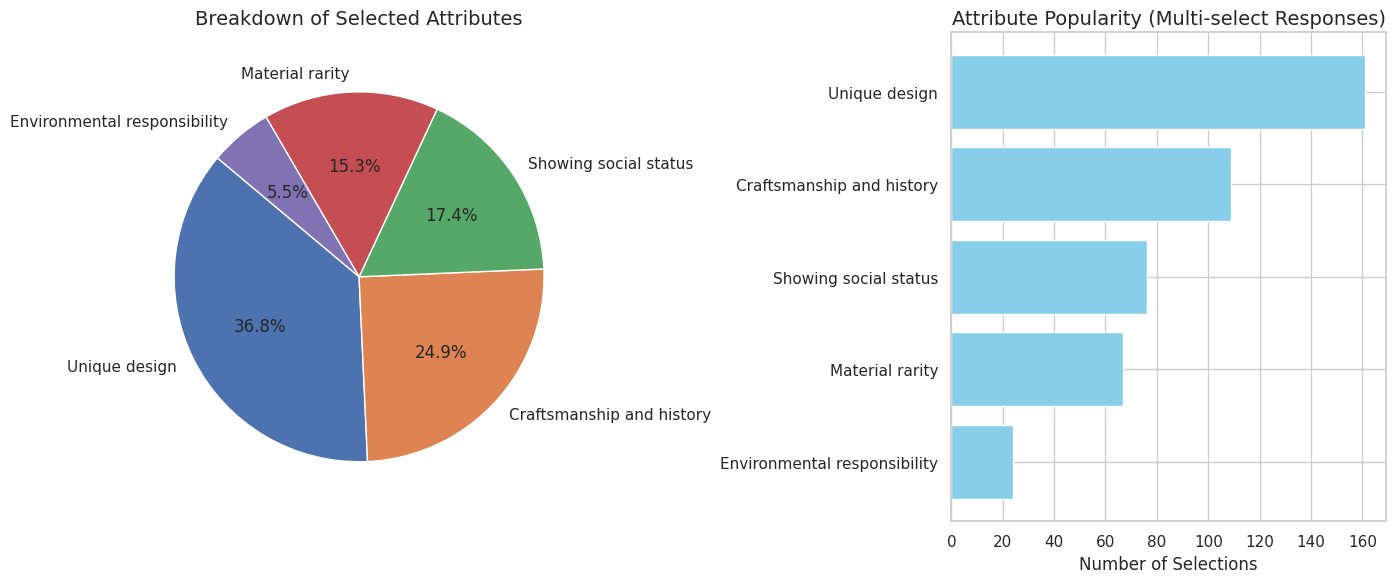

In [49]:
from collections import Counter

# Step 1: Extract and clean multi-select responses from column 21 (index 20)
raw_responses = df.iloc[:, 21].dropna()

# Step 2: Flatten all selected attributes
all_options = []
for response in raw_responses:
    parts = [x.strip() for x in str(response).split(',')]
    all_options.extend(parts)

# Step 3: Count occurrences
option_counts = Counter(all_options)
option_series = pd.Series(option_counts).sort_values(ascending=False)

# Step 4: Plot using plt with subplots
fig = plt.figure(figsize=(14, 6))

# Subplot 1: Pie chart
ax1 = plt.subplot(1, 2, 1)
ax1.pie(option_series, labels=option_series.index, autopct='%1.1f%%', startangle=140)
ax1.set_title("Breakdown of Selected Attributes",fontsize=14)
ax1.axis('equal')

# Subplot 2: Horizontal bar chart
ax2 = plt.subplot(1, 2, 2)
ax2.barh(option_series.index, option_series.values, color='skyblue')
ax2.set_xlabel("Number of Selections")
ax2.set_title("Attribute Popularity (Multi-select Responses)",fontsize=14)
ax2.invert_yaxis()  # most popular at the top

plt.tight_layout()
plt.show()

In [15]:
describe_single_column(df, "scarcity_vs_materials")

2.875 3.0 0    2.0
Name: scarcity_vs_materials, dtype: float64 1.2792472122118113 208
scarcity_vs_materials
1.0    29
2.0    70
3.0    34
4.0    48
5.0    27
Name: count, dtype: int64


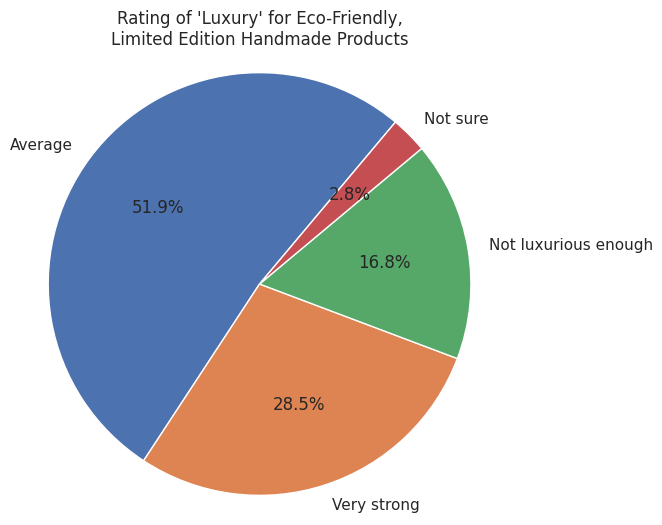

In [57]:
value_counts = df.iloc[:, 22].value_counts(dropna=False)

plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=50)
plt.title("Rating of 'Luxury' for Eco-Friendly,\nLimited Edition Handmade Products", fontsize=12)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

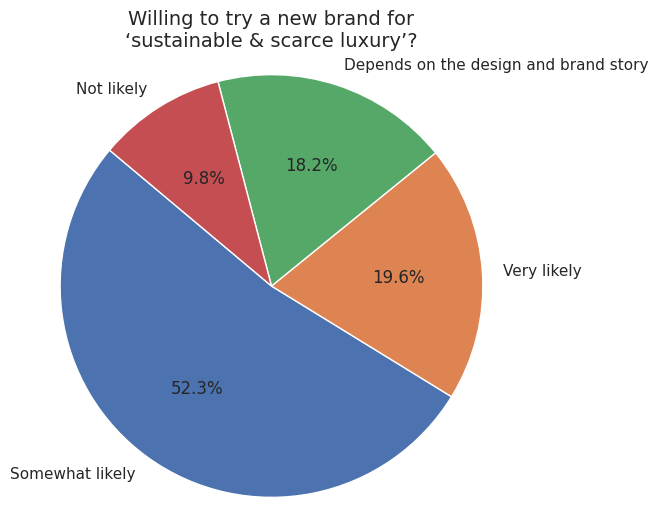

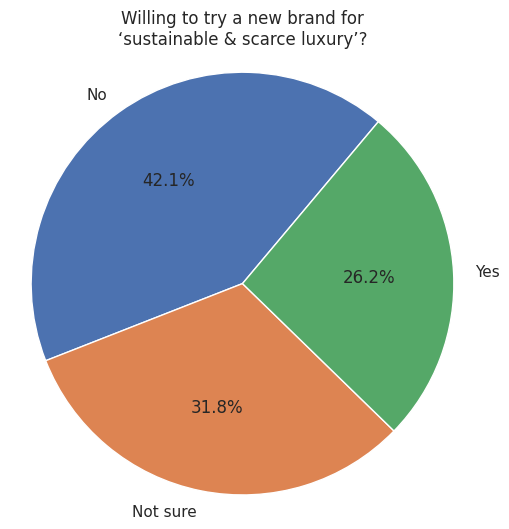

In [65]:
# Column 27/AA
value_counts_27 = df.iloc[:, 26].value_counts(dropna=False)

plt.figure(figsize=(6, 6))
plt.pie(value_counts_27, labels=value_counts_27.index, autopct='%1.1f%%', startangle=140)
plt.title("Willing to try a new brand for\n‘sustainable & scarce luxury’?", fontsize=14)
plt.axis('equal')
plt.show()

# Column 24/X (assuming 24 is index 23, check your comment)
value_counts_24 = df.iloc[:, 23].value_counts(dropna=False)

plt.figure(figsize=(6, 6))
plt.pie(value_counts_24, labels=value_counts_24.index, autopct='%1.1f%%', startangle=50)
plt.title("Willing to try a new brand for\n‘sustainable & scarce luxury’?", fontsize=12)
plt.axis('equal')
plt.show()

# Generational & Regional Difference

In [ ]:
'''
Index(['timestamp', 'age', 'gender', 'country_region_1', 'country_region_2',
       'education_level', 'income', 'income_2', 'luxury_purchase_freq',
       'care_about_sustainability', 'respect_from_sustainability',
       'willing_to_pay_more_eco', 'recycled_materials_less_premium',
       'sustainability_affects_loyalty', 'scarcity_vs_materials',
       'luxury_from_sustainable_materials', 'luxury_rating_leather',
       'luxury_rating_exotic_skin', 'luxury_rating_recycled_plastic',
       'luxury_rating_bio_materials', 'luxury_rating_vegan_leather',
       'luxury_attributes', 'luxury_rating_limited_eco',
       'eco_materials_reduce_luxury', 'env_factors_influence_choice',
       'prefer_leather_vs_recycled', 'try_sustainable_brand',
       'culture_view_compatibility', 'what_is_sustainable_luxury',
       'regional_view_sustainability'],
'''


material_perception_df = df[['country_region_2', 'respect_from_sustainability',]]
mca_data=material_perception_df
# Run MCA
mca = prince.MCA(n_components=2, random_state=42)
mca = mca.fit(mca_data)

# Print eigenvalues
print("Eigenvalues:")
try:
    print(mca.eigenvalues_)
except AttributeError:
    print("Eigenvalues not available in this version of prince.")

# Print explained inertia (variance)
print("\nExplained Inertia (Variance):")
try:
    for i, inertia in enumerate(mca.explained_inertia_):
        print(f"Dimension {i+1}: {inertia:.4f}")
except AttributeError:
    print("Explained inertia not available in this version of prince.")

# Print coordinates of categories
print("\nCoordinates of Categories:")
print(mca.column_coordinates(mca_data))

# Plot the MCA biplot
row_coords = mca.row_coordinates(mca_data)
col_coords = mca.column_coordinates(mca_data)

plt.figure(figsize=(10, 8))
plt.scatter(row_coords[0], row_coords[1], label='Individuals', alpha=0.6)
plt.scatter(col_coords[0], col_coords[1], label='Categories', marker='x', color='red')

for i, txt in enumerate(col_coords.index):
    plt.annotate(txt, (col_coords.iloc[i, 0], col_coords.iloc[i, 1]), fontsize=9)

plt.title('MCA Biplot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
# Calculate proportions of concern levels per age and region

def age_region_stack_bar(dataset, question, order=None, title=None):
  import matplotlib.cm as cm
  import matplotlib.colors as mcolors
  dataset['Age_Region'] = dataset['country_region_2'] + ", " + dataset['age']

  # reorder order
  counts = pd.crosstab(dataset['Age_Region'], dataset[question])
  counts = counts[order]

  # Convert to proportions (100% per row)
  proportions = counts.div(counts.sum(axis=1), axis=0)

  # Reverse the column order and color palette so stack goes bottom-to-top in concern_order
  #reversed_order = order[::-1]
  colors = sns.color_palette('muted', n_colors=len(order))[::-1]

  # Plot
  # Use the "Blues" colormap — good for ordered levels
  cmap = cm.get_cmap('Blues', len(order)+1)
  colors = [mcolors.to_hex(cmap(i)) for i in range(len(order)+1)]
  colors = colors[::-1]

  ax = proportions[order].plot(
      kind='bar',
      stacked=True,
      figsize=(12, 6),
      color=colors
  )

  # Set legend in original (non-reversed) order to match labels logically
  handles, labels = ax.get_legend_handles_labels()
  label_to_handle = dict(zip(labels, handles))
  ax.legend(
      [label_to_handle[l] for l in order],
      order,
      title="Legend",
      bbox_to_anchor=(1.05, 1),
      loc='upper left'
  )
  # Final polish
  if title:
    plt.title(title, fontsize=14)
  else:
    plt.title(question, fontsize=14)
  plt.xlabel("Age & Region Group")
  plt.ylabel("Proportion of Responses")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()


/tmp/ipython-input-1850954911.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



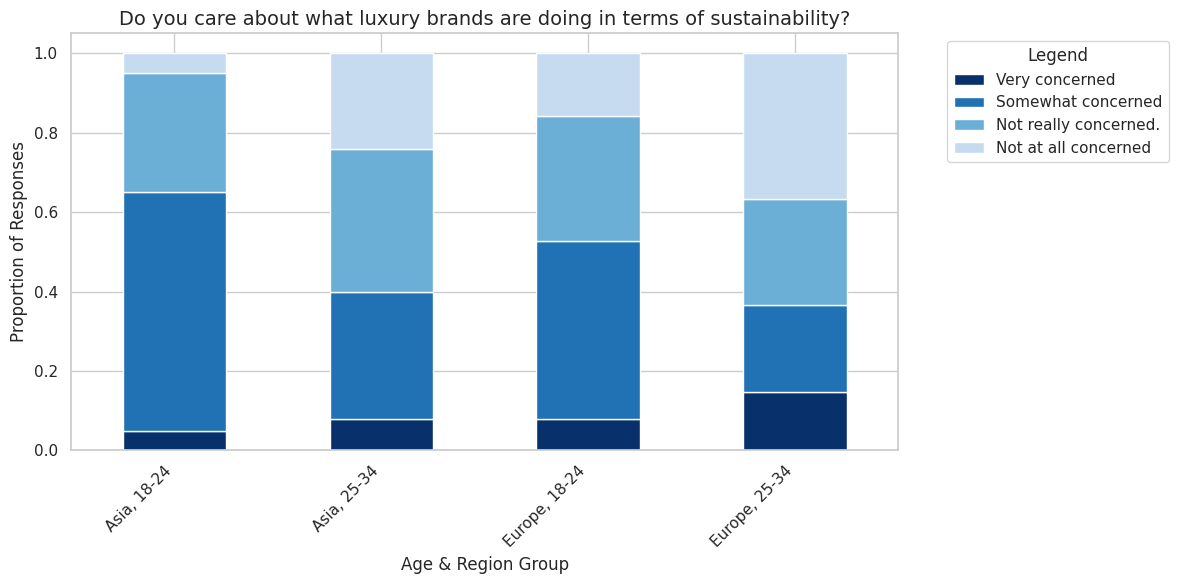

/tmp/ipython-input-1850954911.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



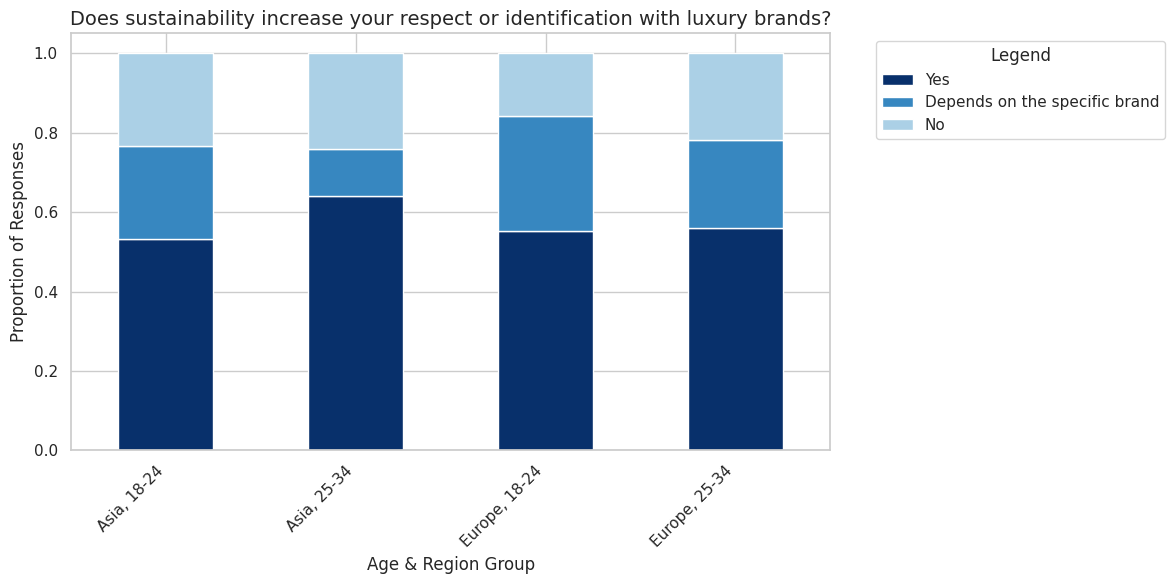

/tmp/ipython-input-1850954911.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



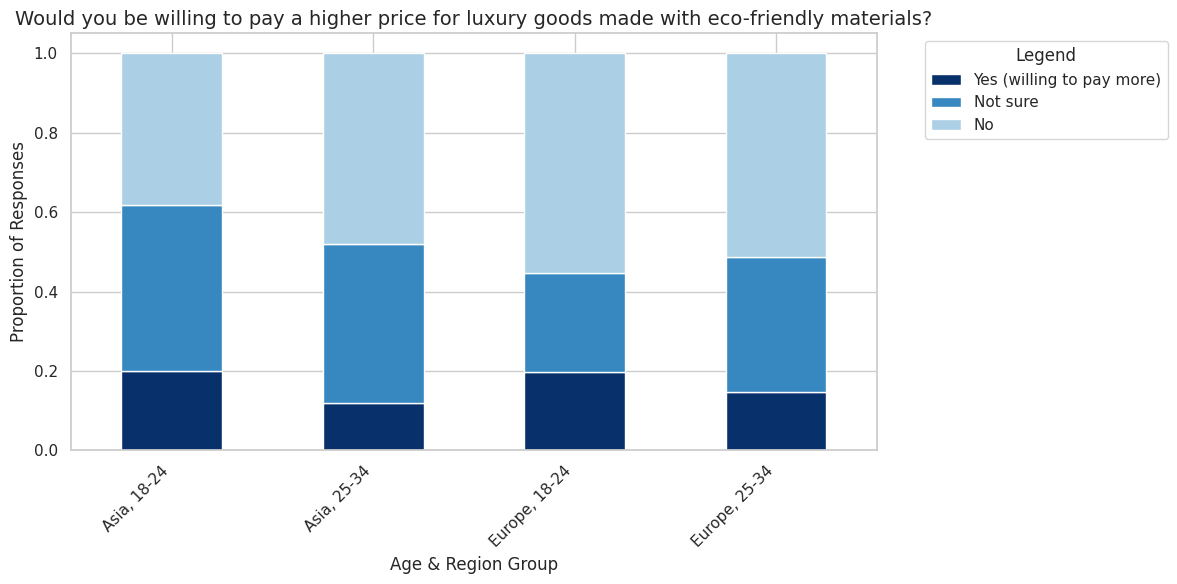

In [70]:
### Section B: Attitudes Toward Sustainability in Luxury ###
age_region_stack_bar(df, "care_about_sustainability", order = ['Very concerned', 'Somewhat concerned', 'Not really concerned.', 'Not at all concerned'], title="Do you care about what luxury brands are doing in terms of sustainability?")
age_region_stack_bar(df, "respect_from_sustainability", order = ['Yes', 'Depends on the specific brand', 'No'], title="Does sustainability increase your respect or identification with luxury brands?")
age_region_stack_bar(df, "willing_to_pay_more_eco", order = ['Yes (willing to pay more)', 'Not sure', 'No'], title="Would you be willing to pay a higher price for luxury goods made with eco-friendly materials?")



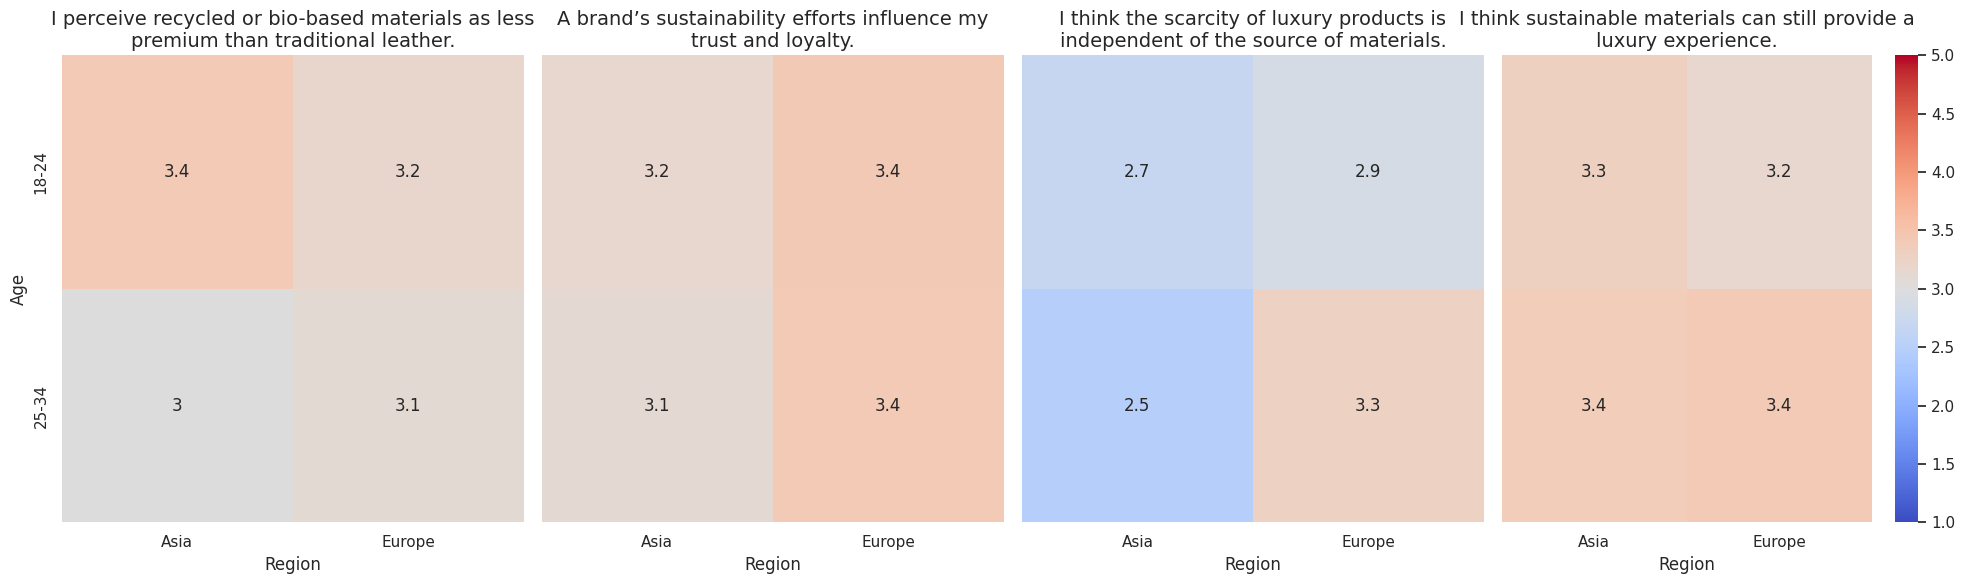

In [73]:
### Section B: Attitudes Toward Sustainability in Luxury ###

# Suppose rating_cols are your multiple rating columns
rating_cols = ["recycled_materials_less_premium",
    "sustainability_affects_loyalty",
    "scarcity_vs_materials",
    "luxury_from_sustainable_materials",]

# Collect all pivot tables first
pivots = [df.pivot_table(values=rating, index='age', columns='country_region_2') for rating in rating_cols]

# Find global min and max across all pivots for consistent color scale
vmin = min(p.min().min() for p in pivots)
vmax = max(p.max().max() for p in pivots)

# Setup subplots: 1 row, len(rating_cols) columns
fig, axes = plt.subplots(1, len(rating_cols), figsize=(5 * len(rating_cols), 6), sharey=True)

import textwrap

for i, (rating, ax) in enumerate(zip(rating_cols, axes)):
    subtitles = [
        'I perceive recycled or bio-based materials as less premium than traditional leather.',
        'A brand’s sustainability efforts influence my trust and loyalty.',
        'I think the scarcity of luxury products is independent of the source of materials.',
        'I think sustainable materials can still provide a luxury experience.'
    ]

    # Wrap long subtitles
    wrapped_title = textwrap.fill(subtitles[i], width=50)  # Adjust width as needed
    sns.heatmap(pivots[i], annot=True, cmap='coolwarm', vmin=1, vmax=5, ax=ax, cbar=(i == len(rating_cols) - 1))
    ax.set_title(wrapped_title, fontsize=14)  # smaller font if needed

    ax.set_xlabel('Region')
    ax.set_ylabel('Age' if i == 0 else '')

plt.tight_layout()
plt.show()

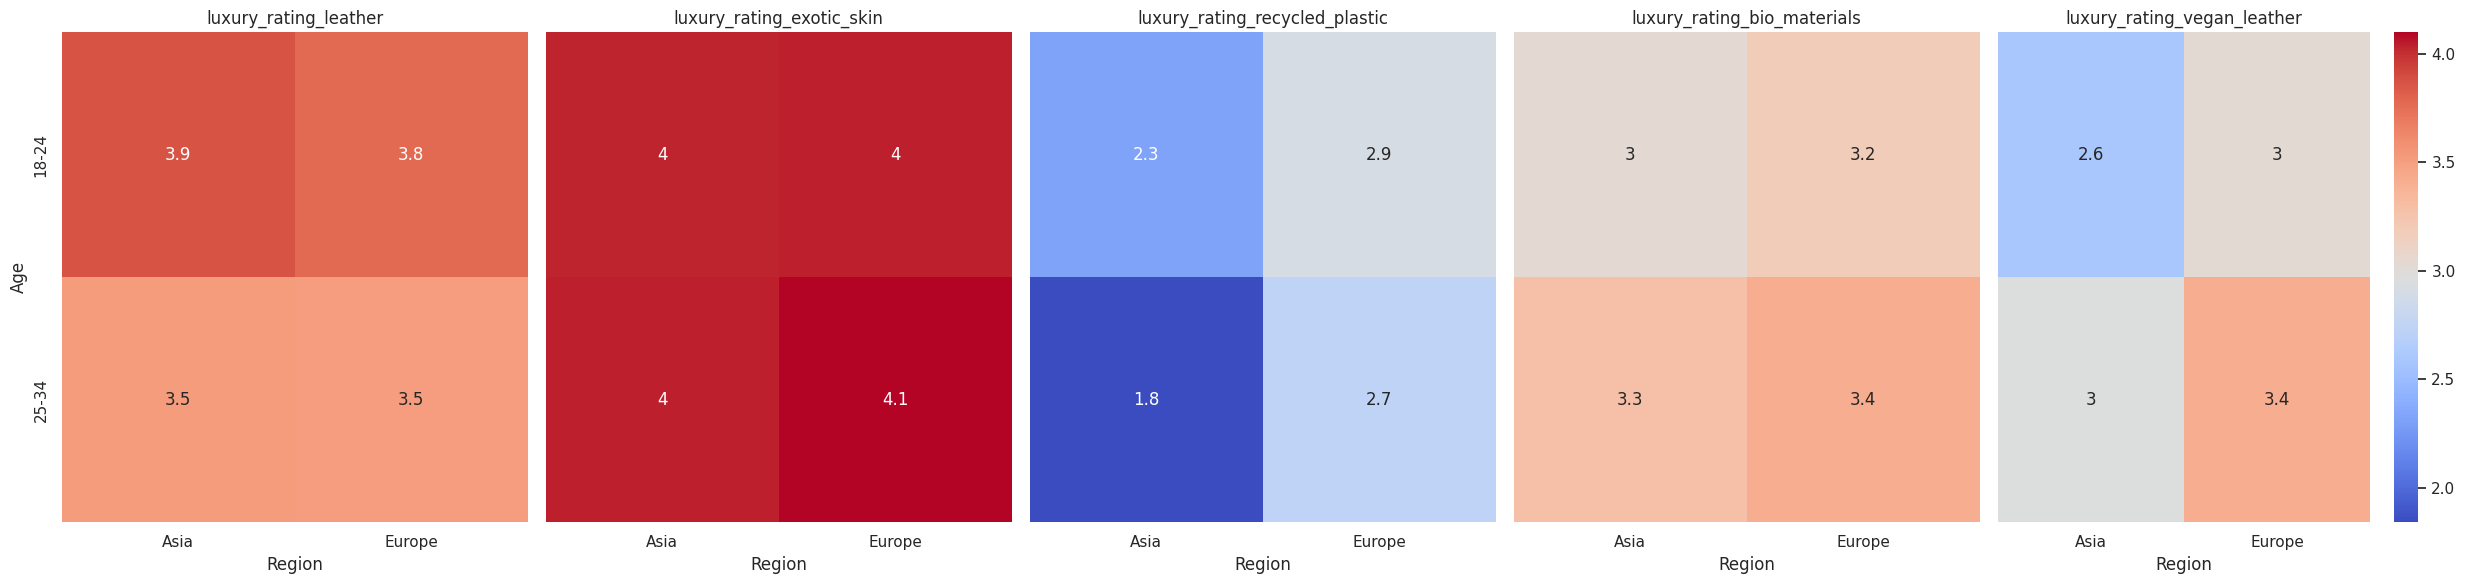

In [74]:
### Section C: Perception of Materials ###

dataset = df[['age', 'country_region_2', 'luxury_rating_leather', 'luxury_rating_exotic_skin', 'luxury_rating_recycled_plastic', 'luxury_rating_bio_materials', 'luxury_rating_vegan_leather'
]]


# Suppose rating_cols are your multiple rating columns
rating_cols = ['luxury_rating_leather', 'luxury_rating_exotic_skin',
               'luxury_rating_recycled_plastic', 'luxury_rating_bio_materials',
               'luxury_rating_vegan_leather']

# Collect all pivot tables first
pivots = [dataset.pivot_table(values=rating, index='age', columns='country_region_2') for rating in rating_cols]

# Find global min and max across all pivots for consistent color scale
vmin = min(p.min().min() for p in pivots)
vmax = max(p.max().max() for p in pivots)

# Setup subplots: 1 row, len(rating_cols) columns
fig, axes = plt.subplots(1, len(rating_cols), figsize=(5 * len(rating_cols), 6), sharey=True)

for i, (rating, ax) in enumerate(zip(rating_cols, axes)):
    sns.heatmap(pivots[i], annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, ax=ax, cbar=(i == len(rating_cols) - 1))
    ax.set_title(rating)
    ax.set_xlabel('Region')
    if i == 0:
        ax.set_ylabel('Age')
    else:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()



/tmp/ipython-input-5247139.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-5247139.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



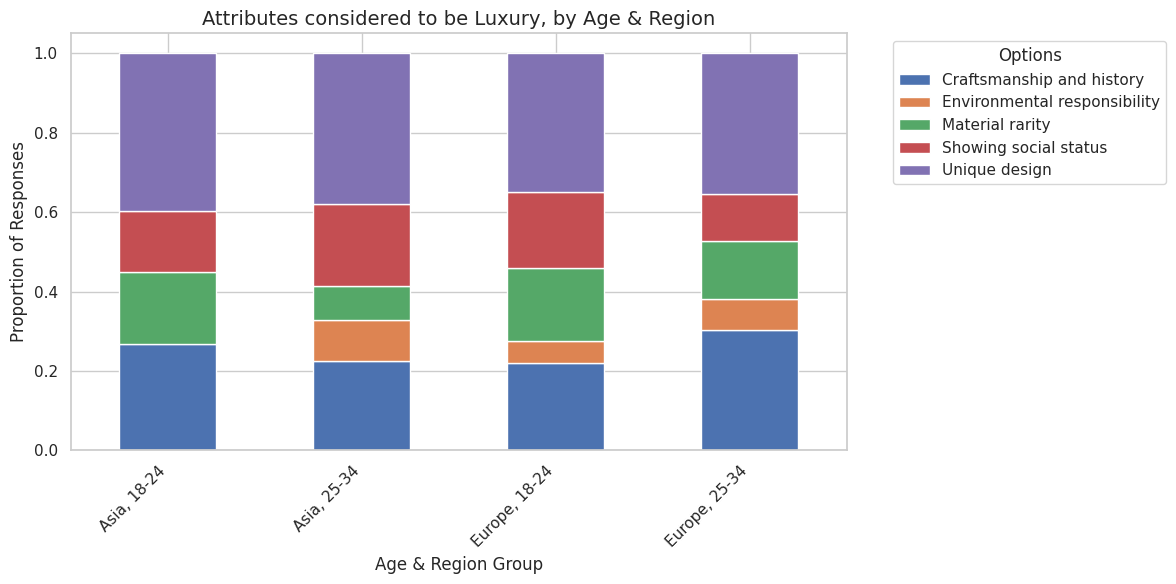

In [77]:
### Section D: Scarcity & Luxury Value PerceptioN ###
def multi_response_stack_bar(dataset, question_col, age_col='age', region_col='country_region_2', title=None ):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Combine Age and Region
    dataset['Age_Region'] = dataset[region_col] + ", " + dataset[age_col]

    # Split multi-response strings into lists
    import re

    def smart_split_clean(response):
        if pd.isna(response):
            return []
        parts = re.findall(r'(?:[^,(]|\([^)]*\))+', response)
        return [p.strip() for p in parts if p.strip()]

    dataset['Options_List'] = dataset[question_col].dropna().apply(smart_split_clean)
    #dataset['Options_List'] = dataset[question_col].str.split(",\s*")  # split by comma + optional space

    # Explode to long format (one option per row)
    exploded = dataset.explode('Options_List')

    # Count frequency of each option per Age_Region
    counts = pd.crosstab(exploded['Age_Region'], exploded['Options_List'])

    # Convert counts to proportions per Age_Region (row-wise)
    proportions = counts.div(counts.sum(axis=1), axis=0)

    # Sort options alphabetically or by your preferred order
    option_order = sorted(proportions.columns.tolist())
    proportions = proportions[option_order]

    # Plot stacked bar chart
    #ax = proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Blues')
    ax = proportions.plot(kind='bar', stacked=True, figsize=(12, 6))

    if title:
      plt.title(title, fontsize = 14 )
    else:
      plt.title(f"Distribution of '{question_col}' Responses by Age & Region", fontsize = 14)
    plt.xlabel("Age & Region Group")
    plt.ylabel("Proportion of Responses")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Options', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

dataset = df[['country_region_2', 'age', 'luxury_attributes']]
multi_response_stack_bar(dataset, 'luxury_attributes', title="Attributes considered to be Luxury, by Age & Region")

/tmp/ipython-input-1850954911.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



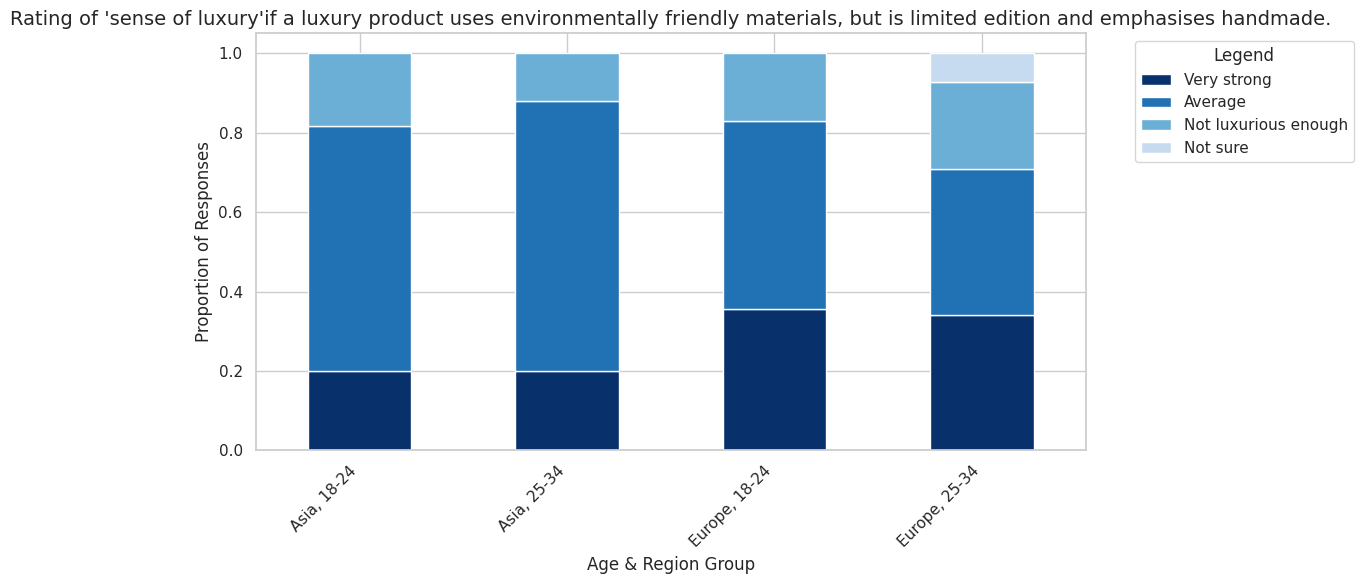

/tmp/ipython-input-1850954911.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



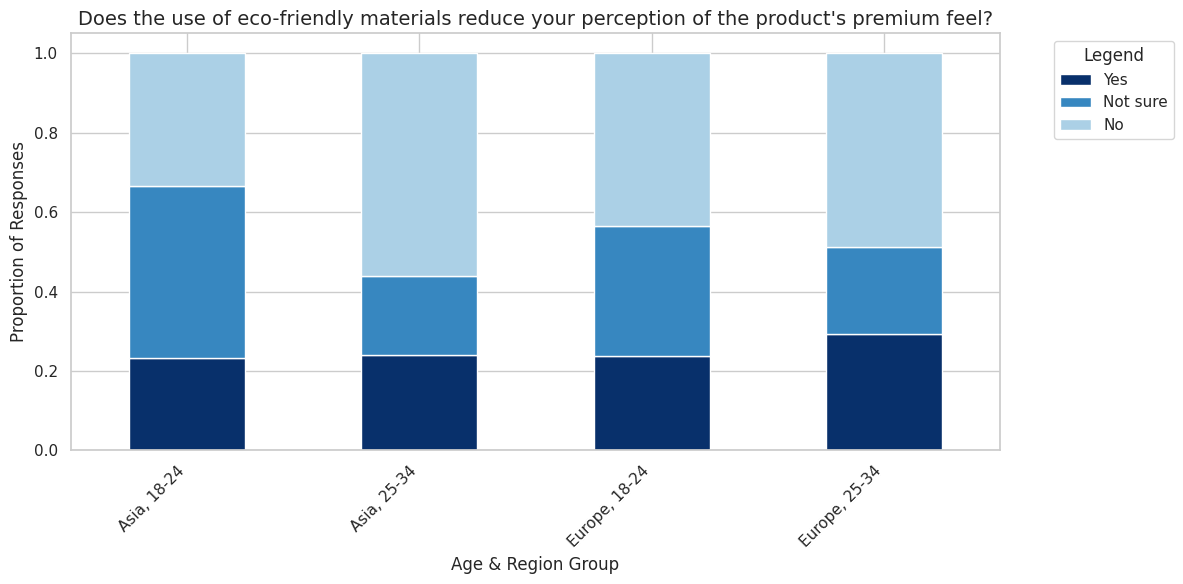

In [79]:
age_region_stack_bar(df, "luxury_rating_limited_eco", order = ['Very strong', 'Average', 'Not luxurious enough', 'Not sure'], title="Rating of 'sense of luxury'if a luxury product uses environmentally friendly materials, but is limited edition and emphasises handmade.")
age_region_stack_bar(df, "eco_materials_reduce_luxury", order = ['Yes', 'Not sure', 'No'], title="Does the use of eco-friendly materials reduce your perception of the product's premium feel?")


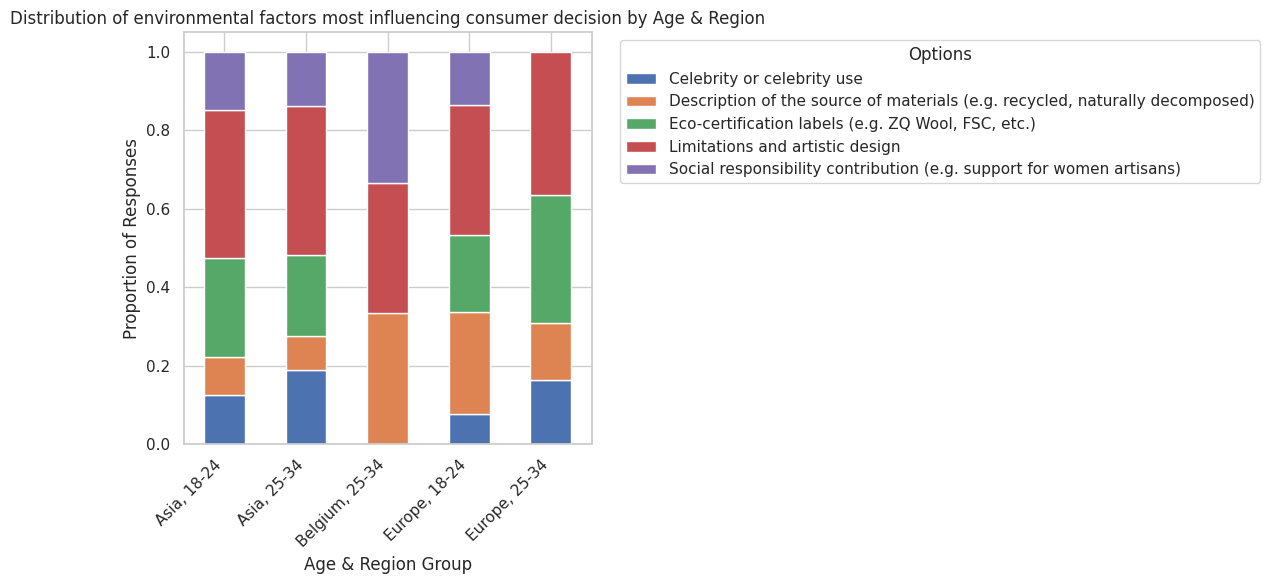

In [25]:
### Section E: Brand Communication & Willingness to Buy ###
'''
"env_factors_influence_choice",
    "prefer_leather_vs_recycled",
    "try_sustainable_brand",
    "culture_view_compatibility",
    "what_is_sustainable_luxury",
    "regional_view_sustainability"
'''
multi_response_stack_bar(df, 'env_factors_influence_choice', title="Distribution of environmental factors most influencing consumer decision by Age & Region")

/tmp/ipython-input-3434877335.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



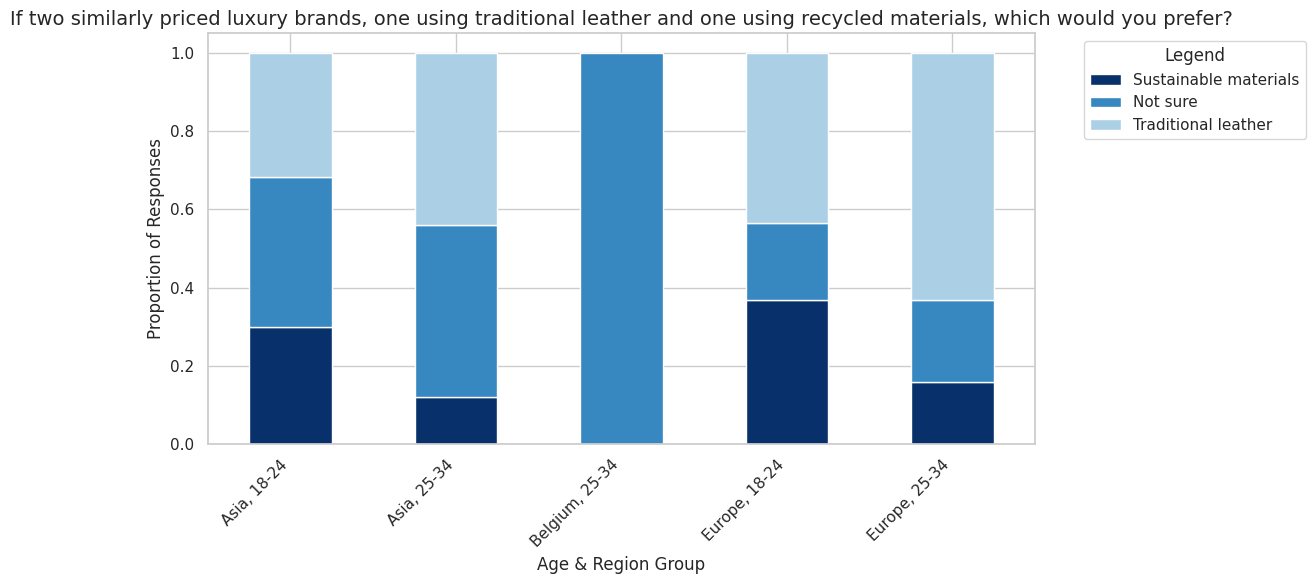

/tmp/ipython-input-3434877335.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



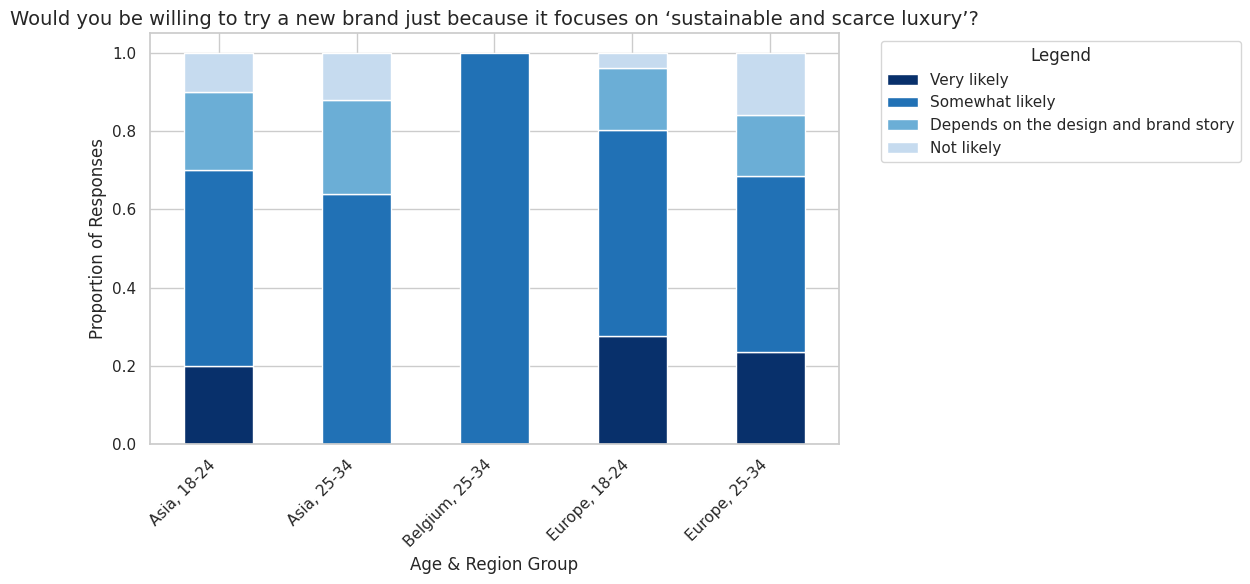

In [26]:
age_region_stack_bar(df, "prefer_leather_vs_recycled", order = ['Sustainable materials', 'Not sure', 'Traditional leather'], title="If two similarly priced luxury brands, one using traditional leather and one using recycled materials, which would you prefer?")
age_region_stack_bar(df, "try_sustainable_brand", order = ['Very likely', 'Somewhat likely', 'Depends on the design and brand story', 'Not likely'], title="Would you be willing to try a new brand just because it focuses on ‘sustainable and scarce luxury’?")


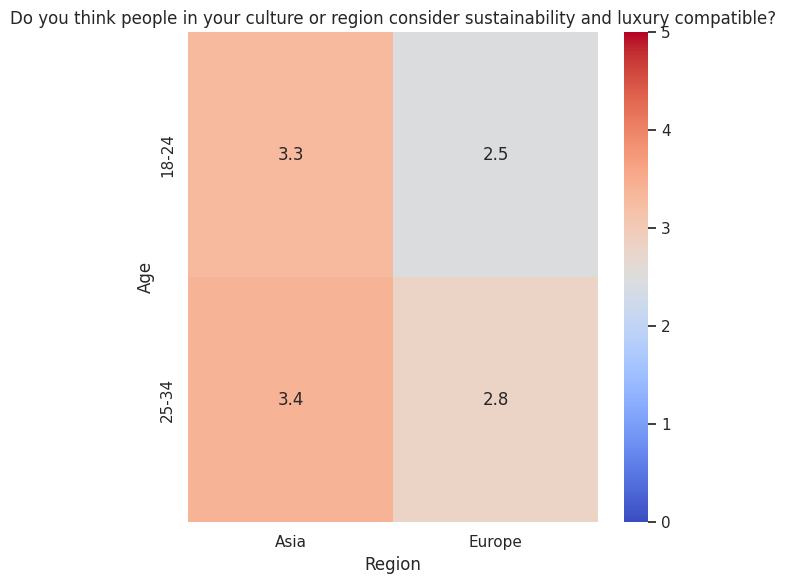

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

rating_col = 'culture_view_compatibility'

# Create pivot table
pivot = df.pivot_table(values=rating_col, index='age', columns='country_region_2')

# Define color scale limits
vmin = pivot.min().min()
vmax = pivot.max().max()

# Set up single plot
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(pivot, annot=True, cmap='coolwarm', vmin=0, vmax=5, ax=ax)
ax.set_title('Do you think people in your culture or region consider sustainability and luxury compatible?')
ax.set_xlabel('Region')
ax.set_ylabel('Age')

plt.tight_layout()
plt.show()
